In [162]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import numpy as np
from IPython.display import display
from statsmodels.tsa.stattools import acf

In [163]:
def modify_image_array(img_array):
    
    pixel_values = np.array(img_array).flatten()  # Flatten the 2D image into 1D pixel array
    mean = np.mean(pixel_values)
    std_dev = np.std(pixel_values)

    # Determine the lower and upper bounds for the 0.001 probability limits
    control_limit = 3.1* std_dev
    upper_control_limit = mean + control_limit
    lower_control_limit = mean - control_limit

    # Identify pixels outside the bounds
    outlier_pixels = np.logical_or(pixel_values > upper_control_limit, pixel_values < lower_control_limit)

    # Create a copy of the pixel values to modify
    modified_pixels = pixel_values.copy()

    # Set the outlier pixels to 0 (black)
    modified_pixels[outlier_pixels] = 0

    # Reshape the modified pixels back to the original image shape
    modified_image_array = modified_pixels.reshape(img_array.shape)
    return modified_image_array

In [164]:
def DrawCircle(img,img_array,rad=3):
    copy_img=img.copy()
    draw = ImageDraw.Draw(copy_img)
    for idx, is_outlier in enumerate(img_array.flatten()):
        if is_outlier==0:
            x = idx % img.width
            y = idx // img.width
            radius = rad  # radius of the circle
            draw.ellipse((x-radius, y-radius, x+radius, y+radius), outline="red", width=2)
    return copy_img

In [165]:
def modify_array(arr,original_arr,window_r=2):
    rows, cols = arr.shape
    for i in range(rows):
        for j in range(cols):
            # Check if the current element is 0
            if arr[i, j] == 0:
                # Define the boundaries for the 11x11 frame
                row_start = max(i - window_r, 0)
                row_end = min(i + window_r+1, rows)
                col_start = max(j - window_r, 0)
                col_end = min(j + window_r+1, cols)
                
                # Extract the 11x11 frame, considering edge cases
                frame = arr[row_start:row_end, col_start:col_end]
                
                # Check if there are no other 0s in the frame
                if np.sum(frame == 0) <= window_r:
                    arr[i, j] = original_arr[i,j]
    return arr

In [166]:
# The user has uploaded a grayscale image. Let's first load this image.
image_name="0080.jpg"
gray_image_path = 'grayimages/'+image_name
gray_image = Image.open(gray_image_path)

# Convert the image to a numpy array
gray_image_array = np.array(gray_image)


In [167]:
# Calculate the mean pixel intensity for each row
rows_mean = np.mean(gray_image_array, axis=1)
# Calculate the mean pixel intensity for each column
columns_mean = np.mean(gray_image_array, axis=0)

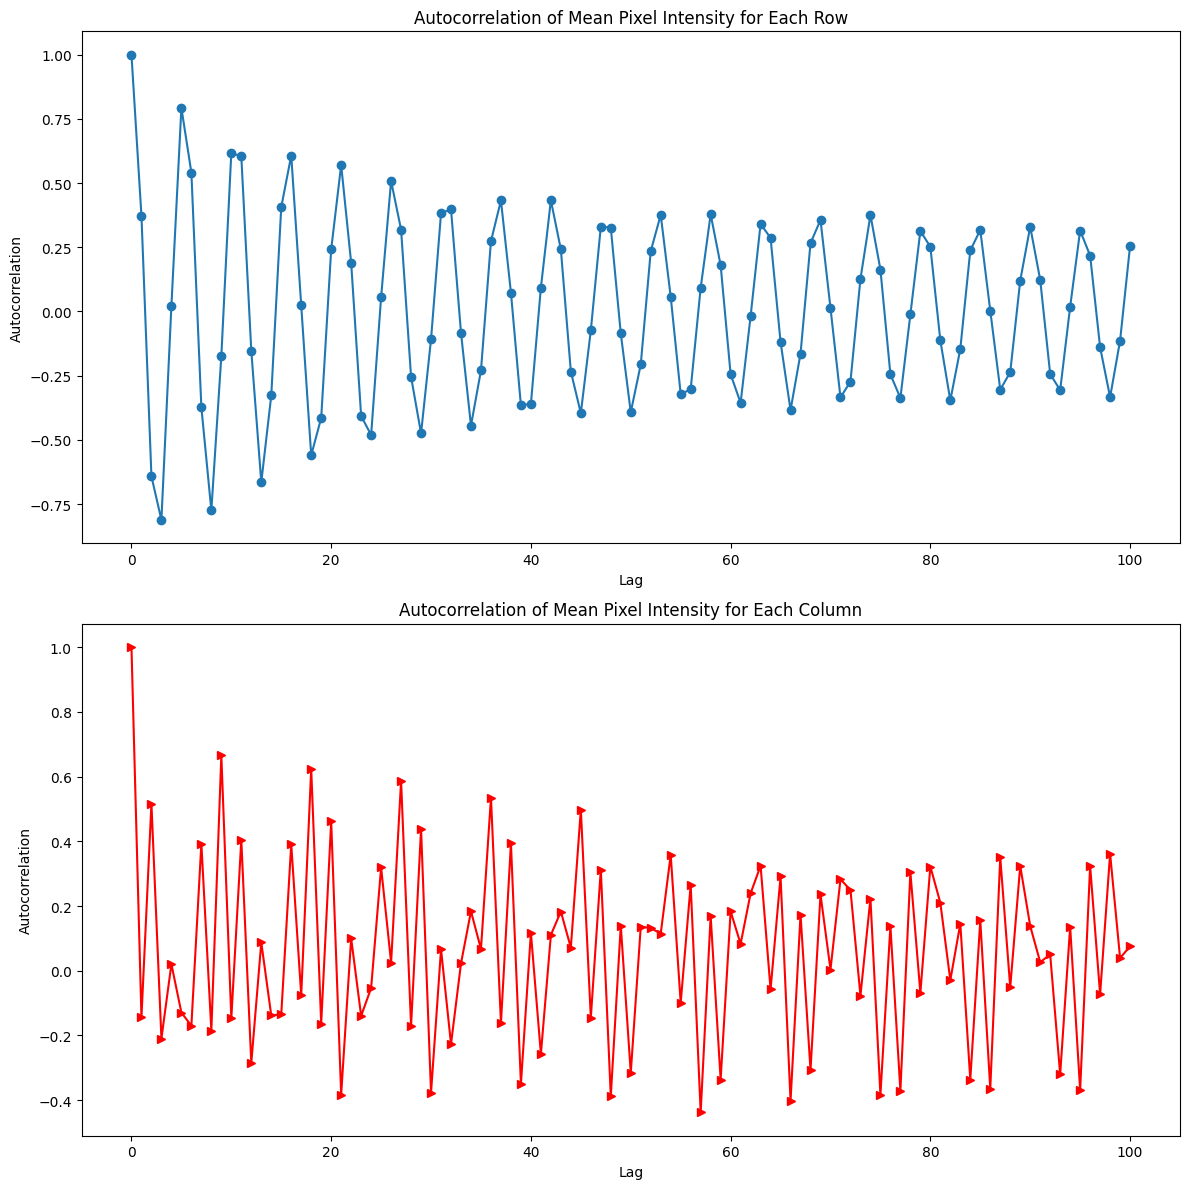

In [168]:
# Compute the autocorrelation of the rows_mean
autocorrelation_row = acf(rows_mean,nlags=100)
# Compute the autocorrelation of the columns_mean
autocorrelation_column = acf(columns_mean,nlags=100)

# Plot the mean and variance for each row in separate plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
# Plot for mean
ax1.plot(autocorrelation_row, marker='o')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Autocorrelation')
ax1.set_title('Autocorrelation of Mean Pixel Intensity for Each Row')
# Plot for mean
ax2.plot(autocorrelation_column, marker='>',color="red")
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')
ax2.set_title('Autocorrelation of Mean Pixel Intensity for Each Column')

fig.tight_layout()
plt.show()


In [169]:
autocorelation_row_num=5
autocorelation_col_num=9

In [170]:
window_size=(102,102)

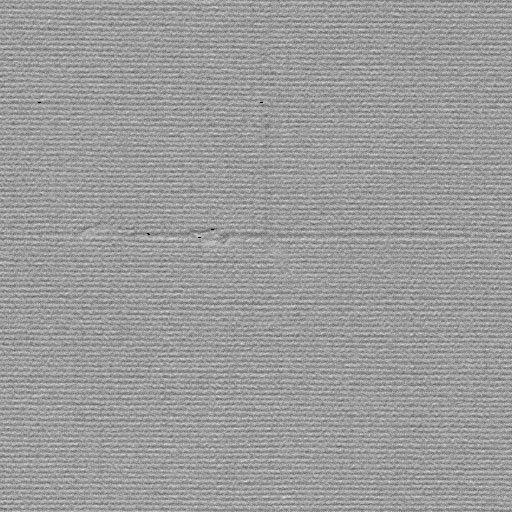

In [171]:
local_modified_image_row_array=gray_image_array.copy()

for i in range(0,local_modified_image_row_array.shape[0] - window_size[0]+1,window_size[0]//2):
    for j in range(0,local_modified_image_row_array.shape[1] - window_size[0]+1,window_size[1]//2):
        # Extract the local window
        local_window = local_modified_image_row_array[i:i + window_size[0],
                                    j:j +window_size[1]].copy()
        for autocorr_i in range(autocorelation_row_num):
            auto_rows = local_window[autocorr_i::autocorelation_row_num]
            for autocorr_j in range(autocorelation_col_num):
                auto_cols = auto_rows.T[autocorr_j::autocorelation_col_num]
                local_array = modify_image_array(auto_cols)
                auto_rows.T[autocorr_j::autocorelation_col_num]= local_array
            local_window[autocorr_i::autocorelation_row_num]=auto_rows
        for x,row in enumerate(local_modified_image_row_array[i:i + window_size[0],j:j +window_size[1]]):
            for y, intgr in enumerate(row):
                if intgr!=0:
                    local_modified_image_row_array[i+x,j+y]= local_window[x,y]
local_modified_image_row_array = modify_array(local_modified_image_row_array,gray_image_array)
local_modified_image_row = Image.fromarray(np.uint8(local_modified_image_row_array))


display(local_modified_image_row)

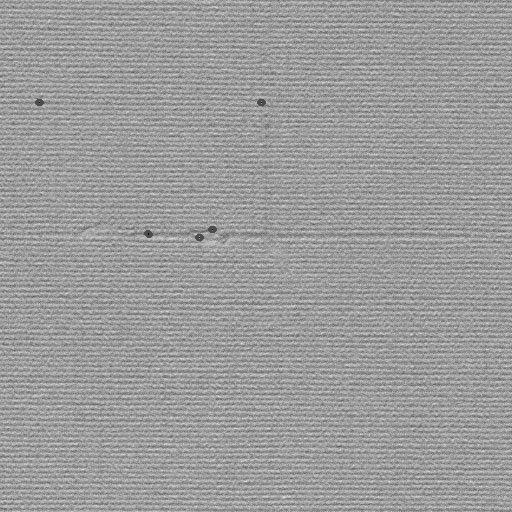

In [172]:
DrawCircle(local_modified_image_row,local_modified_image_row_array)

In [173]:
last_image = DrawCircle(local_modified_image_row,local_modified_image_row_array)

In [174]:
last_image_path = "modifiedimages/"+image_name
last_image.save(last_image_path)